# Validation

In [1]:
# import libraries
import os
import ROOT
import numpy as np
from scipy import stats

Welcome to JupyROOT 6.18/00


In [2]:
# color palette
blue = ROOT.TColor(ROOT.TColor.GetFreeColorIndex(), 31., 119., 180.)
orange = ROOT.TColor(ROOT.TColor.GetFreeColorIndex(), 255., 127., 14.)
green = ROOT.TColor(ROOT.TColor.GetFreeColorIndex(), 44., 160., 44.)
red = ROOT.TColor(ROOT.TColor.GetFreeColorIndex(), 214., 39., 40.)
purple = ROOT.TColor(ROOT.TColor.GetFreeColorIndex(), 148., 103., 189.)
palette = {'blue': blue, 'orange': orange, 'green': green, 'red': red, 'purple': purple}

## 0. Create dataframes

In [3]:
# helpers
def leakageCorrection(col):
    return f"{col}*myPrimaryEnergy/(myPrimaryEnergy-EscapedEnergy)"

def modifiedZscore(rdf, col, D=3.5):
    x = rdf.AsNumpy(columns=[col])[col]
    xtilde = np.median(x)
    MAD = np.median(np.abs(x-xtilde))
    return f"abs(0.6745*({col}-({xtilde}))/{MAD}) <= {D}"

In [4]:
# create rdataframe
treeName = "B4"
path = "/groups/hep/mojen/repositories/DREAM/Run"
fileName = os.path.join(path, "B4.root")
rdf = ROOT.ROOT.RDataFrame(treeName, os.path.join(path, fileName))
# define new columns
rdf = rdf.Define("myPrimaryEnergy", "50000.")  # bug with PrimaryParticleEnergy
rdf = rdf.Define("VectorSignals_corr", leakageCorrection("VectorSignals"))
rdf = rdf.Define("VectorSignalsCher_corr", leakageCorrection("VectorSignalsCher"))
rdf = rdf.Define("Ssum", "Sum(VectorSignals_corr)")
rdf = rdf.Define("Csum", "Sum(VectorSignalsCher_corr)")

## 1. Calibration

### 50 GeV electrons -> S_cal, C_cal

In [5]:
rdf_cal = rdf.Range(100)
# first 100 events are electrons
rdf_cal_S = rdf_cal.Filter("Ssum > 0.", "Cut1").Define("Snorm", "myPrimaryEnergy/Ssum")
rdf_cal_C = rdf_cal.Filter("Csum > 0.", "Cut1").Define("Cnorm", "myPrimaryEnergy/Csum")
# modified Z score
rdf_cal_S = rdf_cal_S.Filter(modifiedZscore(rdf_cal_S, "Snorm"), "Cut2")
rdf_cal_C = rdf_cal_C.Filter(modifiedZscore(rdf_cal_C, "Cnorm"), "Cut2")
# print cuts report
cutsReport_S = rdf_cal_S.Report()
cutsReport_S.Print()
cutsReport_C = rdf_cal_C.Report()
cutsReport_C.Print()

Cut1      : pass=100        all=100        -- eff=100.00 % cumulative eff=100.00 %
Cut2      : pass=98         all=100        -- eff=98.00 % cumulative eff=98.00 %
Cut1      : pass=100        all=100        -- eff=100.00 % cumulative eff=100.00 %
Cut2      : pass=99         all=100        -- eff=99.00 % cumulative eff=99.00 %


 FCN=22.8249 FROM MIGRAD    STATUS=CONVERGED      94 CALLS          95 TOTAL
                     EDM=3.3854e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     2.16740e+00   3.54269e-01   5.95461e-04  -1.75643e-03
   2  Mean         2.29206e+01   1.36821e-01   3.22526e-04   2.34040e-03
   3  Sigma        7.18571e-01   2.20934e-01   2.28824e-04   9.69049e-04
 FCN=21.1493 FROM MIGRAD    STATUS=CONVERGED      92 CALLS          93 TOTAL
                     EDM=3.8622e-09    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     2.49404e+00   3.96290e-01   6.49524e-04   1.95853e-04
   2  Mean         2.23112e+01   2.52125e-01   5.76234e-04   8.13598e-05
   3  Sigma        1.44143e+00   3.

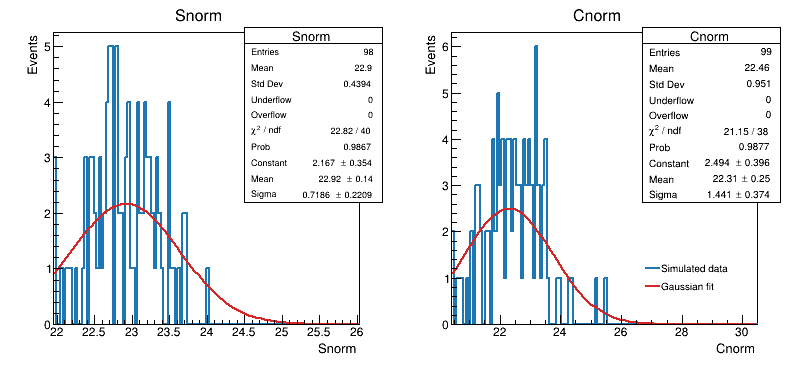

In [6]:
c1 = ROOT.TCanvas("c", "c", 800, 400)
c1.Divide(2)
col = ["Snorm", "Cnorm"]
d = [rdf_cal_S, rdf_cal_C]
h = [None, None]
mean = [None, None]
for i in range(len(col)):
    c1.cd(i+1)
    ROOT.gStyle.SetOptStat("nemr ou")
    ROOT.gStyle.SetOptFit(1111)
    ROOT.gPad.SetLeftMargin(0.12)
    ROOT.gPad.SetBottomMargin(0.12)
    ROOT.gPad.SetRightMargin(0.08)
    ROOT.gPad.SetTopMargin(0.08)
    h[i] = d[i].Histo1D(col[i])
    h[i].GetXaxis().SetTitle(col[i])
    h[i].GetXaxis().SetTitleSize(0.04)
    h[i].GetYaxis().SetTitle("Events")
    h[i].GetYaxis().SetTitleSize(0.04)
    h[i].DrawCopy("E1")
    r = h[i].Fit("gaus", "S")
    h[i].SetLineColor(palette['blue'].GetNumber())
    h[i].SetLineWidth(2)
    gaus = h[i].GetFunction("gaus")
    gaus.SetLineColor(palette['red'].GetNumber())
    gaus.SetLineWidth(2)
    mean[i] = r.Parameter(1)
    rms = r.Parameter(2)
    # add legend
    legend = ROOT.TLegend(0.62, 0.2, 0.82, 0.3)
    legend.SetFillColor(0)
    legend.SetBorderSize(0)
    legend.SetTextSize(0.03)
    legend.AddEntry(h[i].GetValue(), "Simulated data", "l")
    legend.AddEntry(gaus, "Gaussian fit", "l")
    legend.Draw()
    
ROOT.gPad.Modified()
ROOT.gPad.Update()
c1.Draw()

S_cal = mean[0]
C_cal = mean[1]

### 50 GeV pions -> chi

NB! Should use S_cal, C_cal on new independent data which is not done here

In [7]:
rdf_chi = rdf
rdf_chi = rdf_chi.Define("Ssum_cal", f"Ssum*{S_cal}")
rdf_chi = rdf_chi.Define("Csum_cal", f"Csum*{C_cal}")
rdf_chi = rdf_chi.Define("CoverS", "Csum_cal/Ssum_cal")
rdf_chi = rdf_chi.Filter("myPrimaryEnergy > 0.", "Cut3").Define("Snorm_cal", "Ssum_cal/myPrimaryEnergy")
rdf_chi = rdf_chi.Define("Cnorm_cal", "Csum_cal/myPrimaryEnergy")
rdf_chi = rdf_chi.Define("chi", "(1-Snorm_cal)/(1-Cnorm_cal)")

In [8]:
rdf_chi_pi = rdf_chi.Range(100, 200)  # the last 100 events are pions
# modified Z score
rdf_chi_pi = rdf_chi_pi.Filter(modifiedZscore(rdf_chi, "chi"), "Cut2")
# print cuts report
cutsReport_chi_pi = rdf_chi_pi.Report()
cutsReport_chi_pi.Print()

Cut3      : pass=200        all=200        -- eff=100.00 % cumulative eff=100.00 %
Cut2      : pass=100        all=100        -- eff=100.00 % cumulative eff=50.00 %


 FCN=35.5751 FROM MIGRAD    STATUS=CONVERGED      82 CALLS          83 TOTAL
                     EDM=1.58439e-06    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     4.28220e+00   7.61932e-01   1.57614e-03   1.55079e-03
   2  Mean         6.12804e-01   5.39777e-02   1.51582e-04   8.93961e-05
   3  Sigma        3.76748e-01   5.89702e-02   9.78062e-05  -1.50524e-02


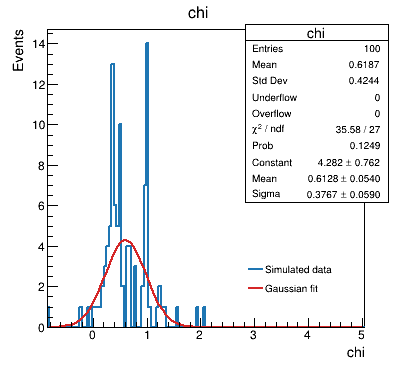

In [9]:
c2 = ROOT.TCanvas("c", "c", 400, 400)
col = ["chi"]
d = [rdf_chi_pi]
h = [None]
mean = [None]
for i in range(len(col)):
    c2.cd(i+1)
    ROOT.gStyle.SetOptStat("nemr ou")
    ROOT.gStyle.SetOptFit(1111)
    ROOT.gPad.SetLeftMargin(0.12)
    ROOT.gPad.SetBottomMargin(0.12)
    ROOT.gPad.SetRightMargin(0.08)
    ROOT.gPad.SetTopMargin(0.08)
    h[i] = d[i].Histo1D(col[i])
    h[i].GetXaxis().SetTitle(col[i])
    h[i].GetXaxis().SetTitleSize(0.04)
    h[i].GetYaxis().SetTitle("Events")
    h[i].GetYaxis().SetTitleSize(0.04)
    h[i].DrawCopy("E1")
    r = h[i].Fit("gaus", "S")
    h[i].SetLineColor(palette['blue'].GetNumber())
    h[i].SetLineWidth(2)
    gaus = h[i].GetFunction("gaus")
    gaus.SetLineColor(palette['red'].GetNumber())
    gaus.SetLineWidth(2)
    mean[i] = r.Parameter(1)
    rms = r.Parameter(2)
    # add legend
    legend = ROOT.TLegend(0.62, 0.2, 0.82, 0.3)
    legend.SetFillColor(0)
    legend.SetBorderSize(0)
    legend.SetTextSize(0.03)
    legend.AddEntry(h[i].GetValue(), "Simulated data", "l")
    legend.AddEntry(gaus, "Gaussian fit", "l")
    legend.Draw()
    
ROOT.gPad.Modified()
ROOT.gPad.Update()
c2.Draw()

chi = mean[0]

## 2. Performance

### Energy resolution

In [10]:
rdf_energy = rdf_chi
rdf_energy_e = rdf_energy.Range(100)
rdf_energy_pi = rdf_energy.Range(100, 200)
# modified Z score
rdf_energy_pi = rdf_energy_pi.Filter(modifiedZscore(rdf_energy_pi, "Snorm_cal")+"&&"+modifiedZscore(rdf_energy_pi, "Cnorm_cal"), "Cut2")
# print cuts report
cutsReport_energy = rdf_energy_pi.Report()
cutsReport_energy.Print()

Cut3      : pass=200        all=200        -- eff=100.00 % cumulative eff=100.00 %
Cut2      : pass=75         all=100        -- eff=75.00 % cumulative eff=37.50 %


In [11]:
# correlation coefficients
SC_e = rdf_energy_e.AsNumpy(columns=["Snorm_cal", "Cnorm_cal"])
SC_pi = rdf_energy_pi.AsNumpy(columns=["Snorm_cal", "Cnorm_cal"])
print(stats.pearsonr(x=SC_e['Snorm_cal'], y=SC_e['Cnorm_cal']))
print(stats.pearsonr(x=SC_pi['Snorm_cal'], y=SC_pi['Cnorm_cal']))

(0.3417071929290715, 0.0005024212562016714)
(0.5204428405019969, 1.7005253657877164e-06)


In [12]:
# rotation method
gr = rdf_energy_pi.Graph("Snorm_cal", "Cnorm_cal")
# linear fit
r = gr.Fit("pol1", "S")


****************************************
Minimizer is Linear
Chi2                      =      2.57226
NDf                       =           73
p0                        =     -0.48428   +/-   0.227444    
p1                        =      1.35419   +/-   0.260047    


In [13]:
p0 = r.Parameter(0)
p1 = r.Parameter(1)
X = p0/(1-p1)
theta = np.pi/2 - np.arctan(p1)
print(p0, p1, X, theta*180/np.pi)

-0.484279786789845 1.3541936728707493 1.367273963040458 36.44389572674465


In [14]:
rotate_xcoord_code = '''
double rotate_xcoord(double x, double y, double angle, double cx) {
    double s = sin(angle);
    double c = cos(angle);
    x -= cx;
    y -= cx;
    double xnew = x * c - y * s;
    double ynew = x * s + y * c;
    x = xnew + cx;
    y = ynew + cx;
    return x;
};
'''
ROOT.gInterpreter.Declare(rotate_xcoord_code)
rotate_ycoord_code = '''
double rotate_ycoord(double x, double y, double angle, double cx) {
    double s = sin(angle);
    double c = cos(angle);
    x -= cx;
    y -= cx;
    double xnew = x * c - y * s;
    double ynew = x * s + y * c;
    x = xnew + cx;
    y = ynew + cx;
    return y;
};
'''
ROOT.gInterpreter.Declare(rotate_ycoord_code)

True

In [15]:
rdf_energy_pi = rdf_energy_pi.Define("PivotPoint", str(X))
rdf_energy_pi = rdf_energy_pi.Define("PivotAngle", str(theta))
rdf_energy_pi = rdf_energy_pi.Define("Snorm_cal_rot", "rotate_xcoord(Snorm_cal, Cnorm_cal, PivotAngle, PivotPoint)")
rdf_energy_pi = rdf_energy_pi.Define("Cnorm_cal_rot", "rotate_ycoord(Snorm_cal, Cnorm_cal, PivotAngle, PivotPoint)")

 FCN=11.9254 FROM MIGRAD    STATUS=CONVERGED      69 CALLS          70 TOTAL
                     EDM=1.41468e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     4.27405e+00   7.52763e-01   9.45088e-04  -8.67862e-04
   2  Mean         1.37097e+00   1.55548e-02   2.46238e-05   2.22366e-02
   3  Sigma        8.88651e-02   1.83163e-02   7.16035e-05  -7.62312e-03


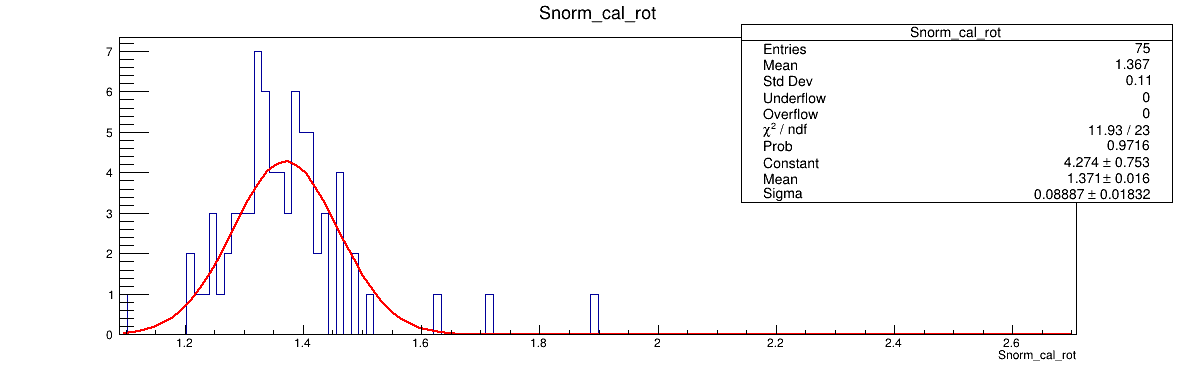

In [16]:
c5 = ROOT.TCanvas("c5", "c5", 1200, 400)
h5c = rdf_energy_pi.Histo1D("Snorm_cal_rot")
h5c.Draw()
rc = h5c.Fit("gaus", "S")
c5.Draw()

In [17]:
# C/E vs S/E
gr1 = rdf_energy_e.Graph("Snorm_cal", "Cnorm_cal")
gr2 = rdf_energy_pi.Graph("Snorm_cal", "Cnorm_cal")
gr1.SetMarkerColor(palette['blue'].GetNumber())
gr2.SetMarkerColor(palette['red'].GetNumber())
gr1.SetMarkerStyle(ROOT.kFullDotSmall)
gr2.SetMarkerStyle(ROOT.kFullDotSmall)

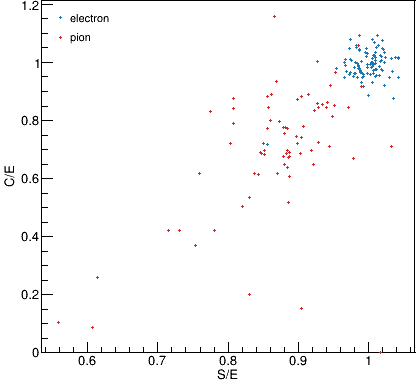

In [18]:
ratio = 7/3
nbins = 40
c1 = ROOT.TCanvas("c1", "c1", 420, 420)
c1.SetRightMargin(0.)
c1.SetTopMargin(0.)
mg = ROOT.TMultiGraph()
mg.Add(gr1.GetPtr())
mg.Add(gr2.GetPtr())
mg.Draw("ap")
mg.GetXaxis().SetTitle("S/E")
mg.GetYaxis().SetTitle("C/E")
mg.GetXaxis().CenterTitle()
mg.GetYaxis().CenterTitle()
# add legend
legend = ROOT.TLegend(0.12, 0.88, 0.32, 0.98)
legend.SetFillColor(0)
legend.SetBorderSize(0)
legend.SetTextSize(0.03)
legend.AddEntry(gr1.GetValue(), "electron", "p")
legend.AddEntry(gr2.GetValue(), "pion", "p")
legend.Draw()
c1.Draw()
c1.Print("hXY.png")

 FCN=21.4886 FROM MIGRAD    STATUS=CONVERGED      89 CALLS          90 TOTAL
                     EDM=7.73458e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     4.58222e+00   1.32190e+00   1.45058e-03   4.30171e-04
   2  Mean         8.83014e-01   1.34899e-02   2.49539e-05   4.02707e-03
   3  Sigma        6.85120e-02   2.36313e-02   1.04602e-04   7.93945e-03


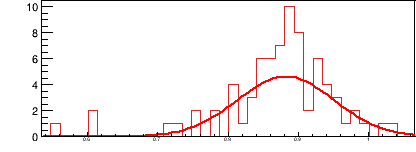

In [19]:
c2 = ROOT.TCanvas("c1", "c1", 420, 180)
c2.SetRightMargin(0.)
c2.SetTopMargin(0.)
modelX = ("", "", nbins, mg.GetXaxis().GetXmin(), mg.GetXaxis().GetXmax())
hX = rdf_energy_pi.Histo1D(modelX, "Snorm_cal")
hX.SetFillStyle(0)
hX.SetLineColor(palette['red'].GetNumber())
# hX.GetXaxis().SetLabelOffset(999)
# hX.GetXaxis().SetLabelSize(0)
hX.GetYaxis().SetLabelSize(mg.GetYaxis().GetLabelSize()*ratio)
rX = hX.Fit("gaus", "S")
hX.SetStats(False)
hX.Draw()
c2.Draw()
c2.Print("hX.png")

 FCN=22.2928 FROM MIGRAD    STATUS=CONVERGED      76 CALLS          77 TOTAL
                     EDM=5.40384e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     4.90546e+00   1.07096e+00   1.60789e-03   7.00816e-04
   2  Mean         4.46506e-01   2.41290e-02   5.65581e-05  -2.24086e-02
   3  Sigma        1.43906e-01   3.46402e-02   9.98616e-05  -1.58605e-03


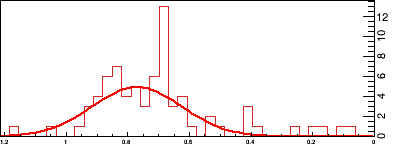

In [20]:
c3 = ROOT.TCanvas("c3", "c3", 420, 180)
c3.SetLeftMargin(0.)
c3.SetTopMargin(0.)
xmin = mg.GetYaxis().GetXmin()
xmax = mg.GetYaxis().GetXmax()
modelY = ("", "", nbins, xmin, xmax)
rdf_energy_pi_rev = rdf_energy_pi
rdf_energy_pi_rev = rdf_energy_pi_rev.Define("reversedCnorm_cal", f"{xmax}-Cnorm_cal+{xmin}")
hY = rdf_energy_pi_rev.Histo1D(modelY, "reversedCnorm_cal")
hY.SetFillStyle(0)
hY.SetLineColor(palette['red'].GetNumber())
hY.GetYaxis().SetLabelSize(mg.GetYaxis().GetLabelSize()*ratio)

rY = hY.Fit("gaus", "S")
hY.SetStats(False)
hY.Draw("Y+")

# Remove the current axis
hY.GetXaxis().SetLabelOffset(999)
hY.GetXaxis().SetTickLength(0)

# Redraw the new axis
ROOT.gPad.Update()
newaxis = ROOT.TGaxis(ROOT.gPad.GetUxmax(), ROOT.gPad.GetUymin(),
                      ROOT.gPad.GetUxmin(), ROOT.gPad.GetUymin(),
                      xmin, xmax, 510, "-")
newaxis.SetLabelOffset(-0.03)
newaxis.Draw()

ROOT.gPad.Update()
for i in range(7):
    hY.GetYaxis().ChangeLabel(i, 90., -1, 23)
c3.Update()
c3.Draw()
c3.Print("hY.png")

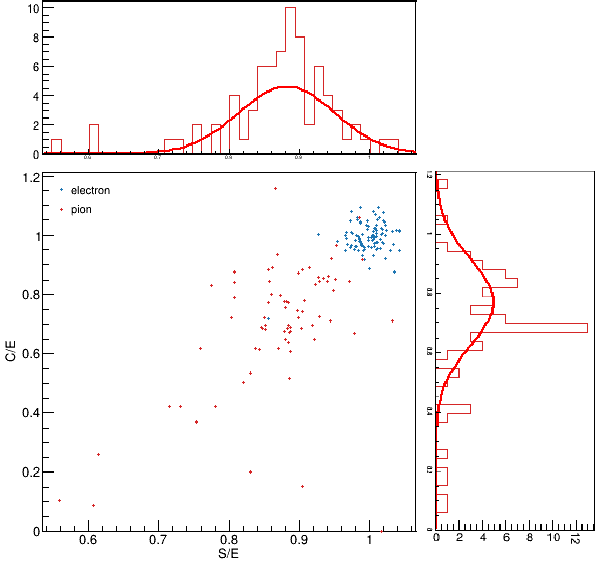

In [21]:
c4 = ROOT.TCanvas("c4", "c4", 600, 600)
pad1 = ROOT.TPad("pad1", "pad1", 0., 0., .7, .7); pad1.Draw()
pad2 = ROOT.TPad("pad2", "pad2", 0., .7, .7, 1.); pad2.Draw()
pad3 = ROOT.TPad("pad3", "pad3", .7, 0., 1., .7); pad3.Draw()
# pad1
pad1.cd()
h_img = ROOT.TImage.Open("hXY.png")
h_img.Draw("x")
pad1.Update()
# pad2
pad2.cd()
hX_img = ROOT.TImage.Open("hX.png")
hX_img.Draw("x")
pad2.Update()
# pad3
pad3.cd()
hY_img = ROOT.TImage.Open("hY.png")
hY_img.Flip(270)
hY_img.Draw("x")
pad3.Update()

c4.Update()
c4.Draw()
c4.Print("final.png")

### Particle identification

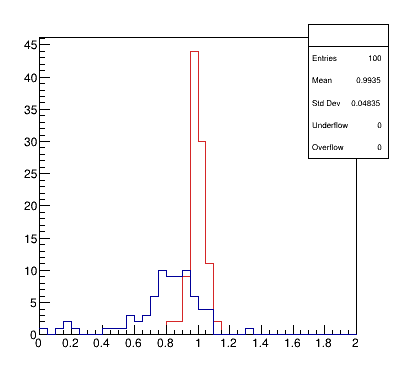

In [22]:
c6 = ROOT.TCanvas("c6", "c6", 400, 400)
model = ("","", 40, 0., 2)
h6_e = rdf_energy_e.Histo1D(model, "CoverS")
h6_pi = rdf_energy_pi.Histo1D(model, "CoverS")
h6_e.SetLineColor(palette['blue'].GetNumber())
h6_e.SetLineColor(palette['red'].GetNumber())
h6_e.Draw()
h6_pi.Draw("same")
c6.Draw()

## 3. Shower profiles

In [23]:
import ROOT

In [24]:
getNij_code = '''
const int Nofmodules = 71;
const int NofFibers = 8;
using namespace ROOT::VecOps;
using ints = RVec<int>;
using doubles = RVec<double>;
ints getNi(doubles v) {
    auto nonzero_idx = Nonzero(v);
    ints module_idx = ints(nonzero_idx) / (NofFibers*NofFibers);
    ints fibre_idx = ints(nonzero_idx) % (NofFibers*NofFibers);
    ints module_i = module_idx / Nofmodules;
    ints fibre_i = fibre_idx / NofFibers;
    return NofFibers*module_i + fibre_i;
};
ints getNj(doubles v) {
    auto nonzero_idx = Nonzero(v);
    ints module_idx = ints(nonzero_idx) / (NofFibers*NofFibers);
    ints fibre_idx = ints(nonzero_idx) % (NofFibers*NofFibers);
    ints module_j = module_idx % Nofmodules;
    ints fibre_j = fibre_idx % NofFibers;
    return NofFibers*module_j + fibre_j;
};
'''
ROOT.gInterpreter.Declare(getNij_code)

True

In [25]:
getWeightedMean_code = '''
using namespace ROOT::VecOps;
double getWeightedMean(const RVec<int> &v, const RVec<double> &w)
{ 
    return Dot(v, w) / Sum(w);
}
'''
ROOT.gInterpreter.Declare(getWeightedMean_code)

getRadialDistance_code = '''
using namespace ROOT::VecOps;
RVec<double> getRadialDistance(const RVec<double> &x, const RVec<double> &y)
{ 
  auto mod = [](double x, double y) { return sqrt(x * x + y * y); };
  return Map(x, y, mod);
}
'''
ROOT.gInterpreter.Declare(getRadialDistance_code)

True

In [26]:
getArange_code ='''
using namespace ROOT::VecOps;
RVec<int> getArange(const int& a)
{ 
  RVec<int> v(a);
  std::iota(std::begin(v), std::end(v), 0);
  return v;
}
'''
ROOT.gInterpreter.Declare(getArange_code)

True

In [27]:
getRadialProfile_code ='''
using namespace ROOT::VecOps;
RVec<double> getRadialProfile(const RVec<double> &r, const RVec<double> &v1, const RVec<double> &xbins)
{
  double v2 = 0.;
  RVec<double> v(xbins.size());
  RVec<bool> c;
  RVec<double> if_c_v1_else_v2;
  for (size_t i = 0; i<xbins.size()-1; ++i) { 
    c = (r >= xbins.at(i)) && (r < xbins.at(i+1));
    if_c_v1_else_v2 = Where(c, v1, v2);
    v.at(i) = Sum(if_c_v1_else_v2);
  }
  return v;
}
'''
ROOT.gInterpreter.Declare(getRadialProfile_code)

True

In [28]:
# create dataframes
treeName = "B4"
path = "/groups/hep/mojen/repositories/DREAM/Run"
rdf_profile = dict()
for s, E in zip(['e10', 'e40'], [10000., 40000.]):
    fileName = os.path.join(path, f"{s}/{s}.root")
    rdf_profile[s] = ROOT.ROOT.RDataFrame(treeName, os.path.join(path, fileName))
    # define new columns
    rdf_profile[s] = rdf_profile[s].Define("myPrimaryEnergy", str(E))
    rdf_profile[s] = rdf_profile[s].Define("VectorSignals_corr", leakageCorrection("VectorSignals"))
    rdf_profile[s] = rdf_profile[s].Define("VectorSignalsCher_corr", leakageCorrection("VectorSignalsCher"))

In [29]:
# rdf_profile = rdf
for s, v, vec in zip(['e10', 'e40'], ["S", "C"], ["VectorSignals_corr", "VectorSignalsCher_corr"]):
    rdf_profile[s] = rdf_profile[s].Define("xbins", "0.6*RVec<double>(getArange(50))")
    rdf_profile[s] = rdf_profile[s].Define(f"{v}_i", f"getNi({vec})")
    rdf_profile[s] = rdf_profile[s].Define(f"{v}_j", f"getNj({vec})")
    rdf_profile[s] = rdf_profile[s].Define(f"{v}_vec", f"Take({vec}, Nonzero({vec}))")
    rdf_profile[s] = rdf_profile[s].Define(f"{v}_vec_norm", f"{v}_vec/Sum({v}_vec)")
    rdf_profile[s] = rdf_profile[s].Define(f"{v}_imean", f"getWeightedMean({v}_i, {v}_vec)")
    rdf_profile[s] = rdf_profile[s].Define(f"{v}_jmean", f"getWeightedMean({v}_j, {v}_vec)")
    rdf_profile[s] = rdf_profile[s].Define(f"{v}_r_mm", f"1.5*getRadialDistance({v}_j-{v}_jmean, {v}_i-{v}_imean)")
    rdf_profile[s] = rdf_profile[s].Define(f"{v}_radialProfile", f"getRadialProfile({v}_r_mm, {v}_vec, xbins)")

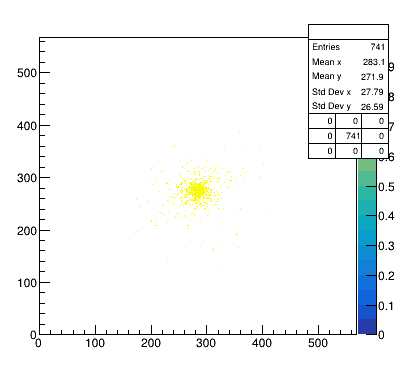

In [30]:
c7 = ROOT.TCanvas("c7", "c7", 400, 400)
model = ("", "", 568, 0., 568., 568, 0., 568.)
h = rdf_profile['e10'].Range(1).Histo2D(model, "S_i", "S_j")
h.Draw("COLZ")
c7.Draw()

In [31]:
binwidth = 0.6
xlow = 0.
xup = 1.5*np.sqrt(2*8**2)
nbins = int(np.ceil((xup-xlow)/binwidth))
xup = nbins*binwidth
print(nbins, xlow, xup)
model = ("", "", nbins, xlow, xup)

29 0.0 17.4


In [32]:
# rdf_profile_e = rdf_profile.Range(100)
# rdf_profile_pi = rdf_profile.Range(100, 200)

Normalized signal INCLUDING under and overflow

The signal is leakage corrected (normalization makes calibration void)

The radial distance ($r_i$) between each individual fiber 𝑖 and the
shower axis was then determined as Eq. 3 Antonello2018

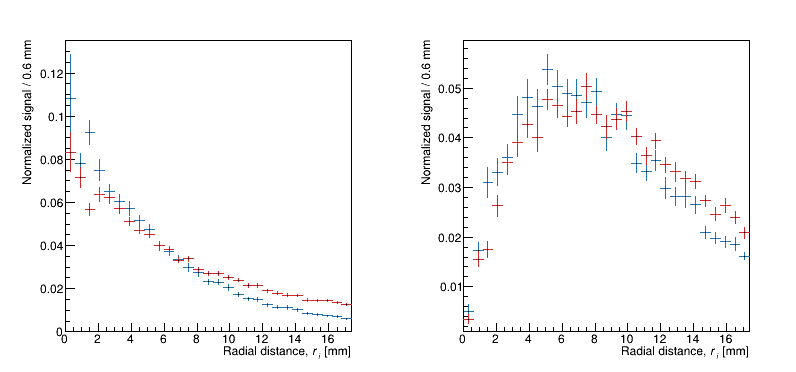

In [33]:
c8 = ROOT.TCanvas("c8", "c8", 800, 400)
ROOT.gStyle.SetOptStat(0)
c8.Divide(2)
x = [["S_r_mm", "C_r_mm"], ["xbins", "xbins"]]
y = [["S_vec", "C_vec"], ["S_radialProfile", "C_radialProfile"]]
# y = [["S_vec_norm", "C_vec_norm"], ["S_radialProfile", "C_radialProfile"]]
p = [[None, None], [None, None]]
p_norm = p.copy()
for i in range(2):
    c8.cd(i+1)
    ROOT.gPad.SetLeftMargin(0.15)
    p[i][0] = rdf_profile['e10'].Profile1D(model, x[i][0], y[i][0])
#     p[i][0].Draw("SAME")
    p_norm[i][0] = p[i][0].DrawNormalized("SAME")
    p[i][1] = rdf_profile['e40'].Profile1D(model, x[i][1], y[i][1])
    p_norm[i][1] = p[i][1].DrawNormalized("SAME")
#     p[i][1].Draw("SAME")
    p_norm[i][0].SetLineColor(palette['blue'].GetNumber())
    p_norm[i][1].SetLineColor(palette['red'].GetNumber())
#     p_norm[i][0].GetXaxis().SetRangeUser(0., 7.8)
#     p_norm[i][0].GetYaxis().SetRangeUser(0., .4)
    p_norm[i][0].GetXaxis().SetTitle("Radial distance, #it{r_{i}} [mm]")
    p_norm[i][0].GetYaxis().SetTitle(f"Normalized signal / {binwidth} mm")

c8.Update()
c8.Draw()